### Imports

In [2]:
#system libraries
import sys
import os
import glob
import wave

#some cool libraries
import scipy
import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import resampy
import wx

#some weird legacy libraries
#import pyvst
from pyvst.vstplugin import *

### Global Settings

In [3]:
SAMPLERATE = 44100
BLOCKSIZE = 2048
PADDING = 5.0 #seconds to run plugin after main sample already cut off (reverb..)
VSTPATH = "D:/VST64/Amplifier/Guitar Rig 5.dll"
#VSTPATH = "D:/VST64/Distortion/CamelCrusher.dll"
#VSTPATH = "D:/VST32/Guitar Rig 5.dll"
PYA = pyaudio.PyAudio()

### Functions

In [4]:
def isMono(data):
    if data.ndim == 1:
        return True
    elif data.shape[1] == 2:
        return False
    else:
        raise Exception('Excuse me what the fuck, Code: 0xQWERTY')
    
def assertIsMono(data):
    if not isMono(data):
        raise Exception('Excuse me what the fuck, Code: -1')

def isNonZero(mono_data):
    assertIsMono(mono_data)
    return mono_data[mono_data!=0].shape[0] != 0

def assertIsNonZero(mono_data):
    if not isNonZero(data):
        raise Exception('Excuse me what the fuck, Code: NUL')    
        
def convert_to_float(mono_data, destination_type=numpy.float32):
    # From SciPy Docu:
    # WAV format                Min        Max            NumPy dtype
    # 32-bit floating-point    -1.0        +1.0            float32
    # 32-bit PCM            -2147483648    +2147483647    int32
    # 16-bit PCM            -32768            +32767        int16
    # 8-bit PCM                0            255            uint8
    # VST processes floats. Let's convert it first
    assertIsMono(mono_data)
    olddatatype = mono_data.dtype
    if olddatatype == destination_type:
        return mono_data, olddatatype
    elif olddatatype == 'int16':
        mono_data = mono_data/32767
    elif olddatatype == 'int32':
        mono_data = mono_data/2147483647
    elif  olddatatype == 'uint8':
        mono_data = mono_data/255
    mono_data = np.array(mono_data, dtype=destination_type)
    return mono_data, olddatatype

def convert_float_to_other_type(mono_data, datatype):
    assertIsMono(mono_data)
    curdatatype = mono_data.dtype
    if curdatatype != numpy.float32 and curdatatype != numpy.float64:
        print('Excuse me what the fuck, Warning Code: 0x00001')
        return mono_data
    if datatype == 'int16':
        mono_data = mono_data*32767
    elif datatype == 'int32':
        mono_data = mono_data*2147483647
    elif datatype == 'uint8':
        mono_data = mono_data*255
    mono_data = mono_data.round() #minimal quantization error possible. may need some dithering in the end TODO
    mono_data = mono_data.astype(datatype)
    return mono_data

def raise_gui(plugin):
    app = wx.App()
    frame = wx.Frame(None, -1, "Plugin editor")
    plugin.open_edit(frame.GetHandle())
    rect = plugin.get_erect()
    frame.SetClientSize((rect.right, rect.bottom))
    frame.Show()
    app.MainLoop()
    
def plot_stft(mono_data):
    assertIsMono(mono_data)
    if mono_data.dtype == numpy.float32 or mono_data.dtype == numpy.float64:
        mono_data = convert_float_to_other_type(mono_data, 'int16')
    
    f, t, Zxx = scipy.signal.stft(mono_data,SAMPLERATE)
    amp = 2 * np.sqrt(2)
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
    #plt.specgram(Zxx, Fs=SAMPLERATE)
    plt.yscale('log', nonposy='clip')
    axes = plt.gca()
    axes.set_ylim([20,20000])
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
def play_wav_file(filepath):
    wf = wave.open(filepath, 'rb') #read mode
    stream = PYA.open(format=PYA.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    dataframes = wf.readframes(BLOCKSIZE)
    while data != '':
        stream.write(dataframes)
        dataframes = wf.readframes(BLOCKSIZE)
    stream.stop_stream()
    stream.close()
    
def resample(mono_data, old_f, new_f):
    assertIsMono(mono_data)
    return resampy.resample(mono_data, old_f, new_f)

### Load plugin

##### Load with stupid vst framework

In [5]:
plugin = VSTPlugin(VSTPATH)
plugin.open()
plugin.set_sample_rate(SAMPLERATE)
plugin.set_block_size(2048)
if plugin.has_editor():
    raise_gui(plugin)

#The plugin should be open now. Setup your effect and close it again :)

plugin.resume()

if plugin.can_process_double():
    #print("Testing with doubles (64bits)")
    datatype = numpy.float64
else:
    #print("Testing with floats (32bits)")
    datatype = numpy.float32

### Load samples

##### Find all files in inputpath

In [6]:
inputdir = 'samples/ToProcess/'
savedir = 'samples/Processed/'

savedir = ''.join([savedir,plugin.get_name().decode("utf-8"),'/',plugin.get_program_name().decode("utf-8"),'/'])
savedir

32


'samples/Processed/Guitar Rig 5/Riff Rocker/'

##### Load file

In [7]:
#OLD METHOD
#fileList = glob.glob(inputdir+"*.wav")
#for inputfilepath in fileList:
#    #print(inputfilepath)
#    #Some neat things you can add to filenames..
#    #plugin.get_name(),plugin.get_vendor(),plugin.get_product()
#    #plugin.get_number_of_programs(),plugin.get_program_name(),
#    #plugin.number_of_inputs, plugin.number_of_outputs
#    filebasepath = os.path.basename(inputfilepath)
#    savepath = savedir+filebasepath

In [8]:
for root, dirs, files in os.walk(inputdir, topdown=False):
    for name in files:
        inputfilepath = os.path.join(root, name)
        savefilepath = inputfilepath.replace(inputdir,savedir)
        savedirpath = os.path.dirname(savefilepath)
        if not os.path.exists(savedirpath):
            os.makedirs(savedirpath)

In [9]:
rate, data = scipy.io.wavfile.read(inputfilepath)

isStereo = not isMono(data)

if isStereo:
    print('Stereo signal found')
    dataL = data[:,0]
    dataR = data[:,1]
else:
    dataL = data
    dataR = np.copy(data)
    print('Mono signal found')
    
#Zero Padding after sample
padLength = round(PADDING*SAMPLERATE)
dataL = np.pad(dataL, (0,padLength), 'constant')
dataR = np.pad(dataR, (0,padLength), 'constant')

dataL, olddatatype = convert_to_float(dataL, datatype)
dataR, olddatatype = convert_to_float(dataR, datatype)

Mono signal found


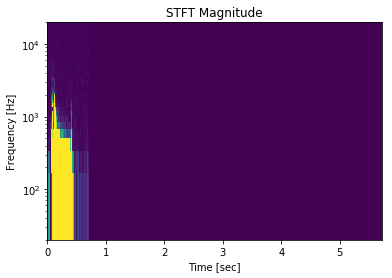

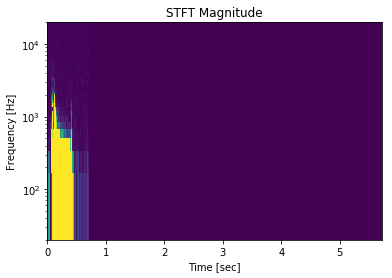

In [10]:
#Have a look on the spectra
plot_stft(dataL)
plot_stft(dataR)



In [11]:
#Normalization
if(rate != SAMPLERATE):
    print("resampling")
    dataL = resample(dataL, rate, 8000)
    dataR = resample(dataR, rate, 8000)

In [12]:
#Init Inputs
if plugin.number_of_inputs == 1:
    input1 = dataL #L
elif plugin.number_of_inputs == 2:
    input1 = dataL #L
    input2 = dataR #R
elif plugin.number_of_inputs == 4:
    input1 = dataL #L
    input2 = dataR #R
    input3 = numpy.zeros(input1.shape, dtype=datatype) #Sidechain L?
    input4 = numpy.zeros(input1.shape, dtype=datatype) #Sidechain R?
else:
    raise Exception('Excuse me what the fuck, Code: I')
#Check if we have some data inside or not
assertIsNonZero(input1)
assertIsNonZero(input2)

### Process Audio

In [13]:
numSamples = input1.shape[0] # 'Length' of sample
output = numpy.zeros((plugin.number_of_outputs, numSamples), dtype=datatype)

for i in range(int(numSamples/BLOCKSIZE)):
    idx_from = i*BLOCKSIZE
    idx_to = (i+1)*BLOCKSIZE
    
    if plugin.number_of_inputs == 1:
        input_samples = [input1[idx_from:idx_to]]
    if plugin.number_of_inputs == 2:
        input_samples = [input1[idx_from:idx_to], input2[idx_from:idx_to]]
    if plugin.number_of_inputs == 4:
        input_samples = [input1[idx_from:idx_to], input2[idx_from:idx_to], input3[idx_from:idx_to], input4[idx_from:idx_to]]
    
    plugin.process(input_samples * int(plugin.number_of_inputs / 2), output[:, idx_from:idx_to])


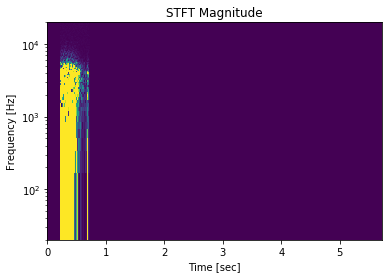

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [52]:
plot_stft(output[0])
output[0]

In [53]:
#Outputs should be nonzero..
assert(output[0][output[0]!=0].shape[0] != 0)
assert(output[1][output[1]!=0].shape[0] != 0)

### Post Processing

##### Crop Part before Hit

In [115]:
#TODO

##### Crop Remainder

In [66]:
#output[0].shape

In [64]:
#output1 = output[0]
#output1[np.abs(output1) < 10*np.finfo(datatype).eps] = 0
#output1 = numpy.trim_zeros(output1,'b')

In [67]:
#plot_stft(output1)

In [68]:
#output1.shape,output1, np.finfo(datatype).eps

In [ ]:
#Assume we have two outputs. If not... rip..
#Trim Zeros from behind
output1 = output[0]
output2 = output[1]
output1[np.abs(output1) < 10*np.finfo(datatype).eps] = 0
output2[np.abs(output2) < 10*np.finfo(datatype).eps] = 0
output1 = numpy.trim_zeros(output[0],'b')
output2 = numpy.trim_zeros(output[1],'b')
maxlength = max(output1.shape[0],output2.shape[0]) #both are not same size not. fill the shorter one with zeros
output1 = np.pad(output1,(0,maxlength-output1.shape[0]),'constant')
output2 = np.pad(output2,(0,maxlength-output2.shape[0]),'constant')
#Convert to old datatype
output1 = convert_float_to_other_type(output1, olddatatype)
output2 = convert_float_to_other_type(output2, olddatatype)

### Save file

In [252]:
#Convert to old datatype
output1 = convert_float_to_other_type(output1, olddatatype)
output2 = convert_float_to_other_type(output2, olddatatype)

outputdata = np.array([output1, output2]).T

In [258]:
scipy.io.wavfile.write(savefilepath, SAMPLERATE, outputdata)

### Play the files (Optional)

In [247]:
play_wav_file(inputfilepath)

d:\codingworkspace\pythonaudioprocessing\venv\lib\site-packages\ipykernel_launcher.py:91: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


KeyboardInterrupt: 

In [259]:
play_wav_file(savepath)

d:\codingworkspace\pythonaudioprocessing\venv\lib\site-packages\ipykernel_launcher.py:91: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


KeyboardInterrupt: 

### Close Plugin

In [33]:
plugin.suspend()

### Close PyAudio Host

In [34]:
PYA.terminate()